<a href="https://colab.research.google.com/github/ant358/tensorflow_projects/blob/main/time_series/TF_time_series_Windowed_dataset_US_weekly_diesel_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf


# This function normalizes the dataset using min max scaling.
# DO NOT CHANGE THIS CODE
def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data


# This function is used to map the time series dataset into windows of
# features and respective targets, to prepare it for training and validation.
# The first element of the first window will be the first element of
# the dataset.
#
# Consecutive windows are constructed by shifting the starting position
# of the first window forward, one at a time (indicated by shift=1).
#
# For a window of n_past number of observations of the time
# indexed variable in the dataset, the target for the window is the next
# n_future number of observations of the variable, after the
# end of the window.

# DO NOT CHANGE THIS.
def windowed_dataset(series, batch_size, n_past=10, n_future=10, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)


# This function loads the data from the CSV file, normalizes the data and
# splits the dataset into train and validation data. It also uses
# windowed_dataset() to split the data into windows of observations and
# targets. Finally it defines, compiles and trains a neural network. This
# function returns the final trained model.

# COMPLETE THE CODE IN THIS FUNCTION
# def solution_model():
# DO NOT CHANGE THIS CODE
# Reads the dataset.
df = pd.read_csv('Weekly_U.S.Diesel_Retail_Prices.csv',
                    infer_datetime_format=True, index_col='Week of', header=0)

# Number of features in the dataset. We use all features as predictors to
# predict all features of future time steps.
N_FEATURES = len(df.columns) # DO NOT CHANGE THIS

# Normalizes the data
data = df.values
data = normalize_series(data, data.min(axis=0), data.max(axis=0))

# Splits the data into training and validation sets.
SPLIT_TIME = int(len(data) * 0.8) # DO NOT CHANGE THIS
x_train = data[:SPLIT_TIME]
x_valid = data[SPLIT_TIME:]

# DO NOT CHANGE THIS CODE
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# DO NOT CHANGE BATCH_SIZE IF YOU ARE USING STATEFUL LSTM/RNN/GRU.
# THE TEST WILL FAIL TO GRADE YOUR SCORE IN SUCH CASES.
# In other cases, it is advised not to change the batch size since it
# might affect your final scores. While setting it to a lower size
# might not do any harm, higher sizes might affect your scores.
BATCH_SIZE = 32  # ADVISED NOT TO CHANGE THIS

# DO NOT CHANGE N_PAST, N_FUTURE, SHIFT. The tests will fail to run
# on the server.
# Number of past time steps based on which future observations should be
# predicted
N_PAST = 10  # DO NOT CHANGE THIS

# Number of future time steps which are to be predicted.
N_FUTURE = 10  # DO NOT CHANGE THIS

# By how many positions the window slides to create a new window
# of observations.
SHIFT = 1  # DO NOT CHANGE THIS

# Code to create windowed train and validation datasets.
train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE,
                                n_past=N_PAST, n_future=N_FUTURE,
                                shift=SHIFT)
valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE,
                                n_past=N_PAST, n_future=N_FUTURE,
                                shift=SHIFT)


In [ ]:
df.head()

,Weekly U.S. No 2 Diesel Retail Prices Dollars per Gallon
Week of,
1994-03-21,1.106
1994-03-28,1.107
1994-04-04,1.109
1994-04-11,1.108
1994-04-18,1.105


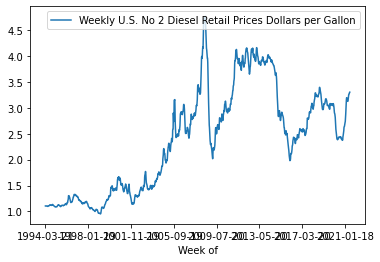

In [ ]:
df.plot()

In [ ]:
len(df.columns)

1

In [ ]:
train_set.flat_map

<bound method DatasetV2.flat_map of <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>>

In [ ]:

# Code to define your model.
model = tf.keras.models.Sequential([

    # ADD YOUR LAYERS HERE.
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='causal', activation='relu', input_shape=[N_PAST, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    # If you don't follow the instructions in the following comments,
    # tests will fail to grade your code:
    # The input layer of your model must have an input shape of:
    # (BATCH_SIZE, N_PAST = 10, N_FEATURES = 1)
    # The model must have an output shape of:
    # (BATCH_SIZE, N_FUTURE = 10, N_FEATURES = 1).
    # Make sure that there are N_FEATURES = 1 neurons in the final dense
    # layer since the model predicts 1 feature.

    # HINT: Bidirectional LSTMs may help boost your score. This is only a
    # suggestion.

    # WARNING: If you are using the GRU layer, it is advised not to use the
    # recurrent_dropout argument (you can alternatively set it to 0),
    # since it has not been implemented in the cuDNN kernel and may
    # result in much longer training times.
    tf.keras.layers.Dense(N_FEATURES)
])

# Code to train and compile the model
optimizer =  tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

model.compile(
    # YOUR CODE HERE
    loss="mae", optimizer=optimizer, metrics=['mae']
)
model.fit(
    # YOUR CODE HERE
    train_set, 
    epochs=100,
    validation_data = valid_set,
    verbose=2
)


Epoch 1/100
35/35 - 10s - loss: 0.2857 - mae: 0.2857 - val_loss: 0.3959 - val_mae: 0.3959 - 10s/epoch - 277ms/step
Epoch 2/100
35/35 - 0s - loss: 0.2849 - mae: 0.2849 - val_loss: 0.3950 - val_mae: 0.3950 - 491ms/epoch - 14ms/step
Epoch 3/100
35/35 - 0s - loss: 0.2841 - mae: 0.2841 - val_loss: 0.3942 - val_mae: 0.3942 - 479ms/epoch - 14ms/step
Epoch 4/100
35/35 - 0s - loss: 0.2834 - mae: 0.2834 - val_loss: 0.3934 - val_mae: 0.3934 - 470ms/epoch - 13ms/step
Epoch 5/100
35/35 - 0s - loss: 0.2827 - mae: 0.2827 - val_loss: 0.3927 - val_mae: 0.3927 - 485ms/epoch - 14ms/step
Epoch 6/100
35/35 - 0s - loss: 0.2820 - mae: 0.2820 - val_loss: 0.3920 - val_mae: 0.3920 - 492ms/epoch - 14ms/step
Epoch 7/100
35/35 - 0s - loss: 0.2814 - mae: 0.2814 - val_loss: 0.3913 - val_mae: 0.3913 - 473ms/epoch - 14ms/step
Epoch 8/100
35/35 - 0s - loss: 0.2808 - mae: 0.2808 - val_loss: 0.3906 - val_mae: 0.3906 - 500ms/epoch - 14ms/step
Epoch 9/100
35/35 - 0s - loss: 0.2802 - mae: 0.2802 - val_loss: 0.3899 - val_mae

In [ ]:
model.summary()

In [ ]:
model.save("c5q12.h5")

In [ ]:
import urllib
import os
import zipfile
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data

def windowed_dataset(series, batch_size, n_past=10, n_future=10, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)


def solution_model():
    df = pd.read_csv('Weekly_U.S.Diesel_Retail_Prices.csv',
                     infer_datetime_format=True, index_col='Week of', header=0)

    N_FEATURES = len(df.columns) 
    data = df.values
    data = normalize_series(data, data.min(axis=0), data.max(axis=0))

    SPLIT_TIME = int(len(data) * 0.8) 
    x_train = data[:SPLIT_TIME]
    x_valid = data[SPLIT_TIME:]

    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    BATCH_SIZE = 32  
    N_PAST = 10  
    N_FUTURE = 10  
    SHIFT = 1 

    train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)
    valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)

    model = Sequential([
                        Conv1D(filters=32, kernel_size=3, padding='causal', activation='relu', input_shape=[N_PAST, 1]),
                        Bidirectional(LSTM(32, return_sequences=True)),
                        Bidirectional(LSTM(32, return_sequences=True)),
                        Dense(32, activation='relu'),
                        Dense(16, activation='relu'),
                        Dense(N_FEATURES)
    ])

    checkpoint_path = 'model/my_checkpoint.ckpt'
    checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                 save_weights_only=True,
                                 save_best_only=True,
                                 monitor='val_loss',
                                 verbose=1)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

    model.fit(train_set,
              validation_data=(valid_set),
              epochs=20,
              callbacks=[checkpoint])
    model.load_weights(checkpoint_path)

    return model

if __name__ == '__main__':
    model = solution_model()
    model.save("model.h5")

Epoch 1/20
     33/Unknown - 6s 14ms/step - loss: 0.0933 - mae: 0.0933
Epoch 1: val_loss improved from inf to 0.13738, saving model to model/my_checkpoint.ckpt
35/35 [==============================] - 7s 64ms/step - loss: 0.0988 - mae: 0.0988 - val_loss: 0.1374 - val_mae: 0.1374
Epoch 2/20
34/35 [============================>.] - ETA: 0s - loss: 0.1345 - mae: 0.1345
Epoch 2: val_loss improved from 0.13738 to 0.08561, saving model to model/my_checkpoint.ckpt
35/35 [==============================] - 1s 16ms/step - loss: 0.1337 - mae: 0.1337 - val_loss: 0.0856 - val_mae: 0.0856
Epoch 3/20
32/35 [==========================>...] - ETA: 0s - loss: 0.0804 - mae: 0.0804
Epoch 3: val_loss improved from 0.08561 to 0.04850, saving model to model/my_checkpoint.ckpt
35/35 [==============================] - 1s 16ms/step - loss: 0.0779 - mae: 0.0779 - val_loss: 0.0485 - val_mae: 0.0485
Epoch 4/20
32/35 [==========================>...] - ETA: 0s - loss: 0.0414 - mae: 0.0414
Epoch 4: val_loss improved 